#1. Setup

Instalación de librerías

In [ ]:
!pip install kagglehub
!pip install tensorflow
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib

Importación de librerías

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# TensorFlow y Keras
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model

# Sklearn para métricas
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

Configuración de GPU

In [ ]:
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
if tf.config.list_physical_devices('GPU'):
    print("Using GPU")
    # Permitir crecimiento de memoria GPU
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)
else:
    print("Using CPU")

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

Configuración de seeds

#2. Datos

Directorios

In [ ]:
PROJECT_ROOT = '/content/drive/MyDrive/DL_Proyecto_MorenoBryan_Clasificacion'
RESULTS_DIR = os.path.join(PROJECT_ROOT, 'results')

In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Descarga del dataset desde Kaggle

In [ ]:
import kagglehub
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cell-images-for-detecting-malaria


Rutas de datos

In [ ]:
data_path = path+"/cell_images/cell_images"
train_dir = os.path.join(data_path, 'train') if os.path.exists(os.path.join(data_path, 'train')) else data_path

Exploración del contenido del dataset

In [ ]:
print("\nEstructura del dataset:")
for root, dirs, files in os.walk(data_path):
    level = root.replace(data_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files[:3]:  # Mostrar solo los primeros 3 archivos
        print(f'{subindent}{file}')
    if len(files) > 3:
        print(f'{subindent}... y {len(files)-3} más')


Estructura del dataset:
cell_images/
  Uninfected/
    C203ThinF_IMG_20151029_102123_cell_51.png
    C238NThinF_IMG_20151207_114038_cell_84.png
    C119P80ThinF_IMG_20151002_124304_cell_112.png
    ... y 13777 más
  Parasitized/
    C99P60ThinF_IMG_20150918_141001_cell_93.png
    C99P60ThinF_IMG_20150918_141001_cell_133.png
    C101P62ThinF_IMG_20150918_151942_cell_60.png
    ... y 13777 más


Conteo de imágenes por clase

In [ ]:
classes = ['Parasitized', 'Uninfected']
class_counts = {}
for class_name in classes:
    class_path = os.path.join(data_path, class_name)
    if os.path.exists(class_path):
        count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        class_counts[class_name] = count
        print(f"{class_name}: {count} imágenes")

print(f"\nTotal de imágenes: {sum(class_counts.values())}")

Parasitized: 13779 imágenes
Uninfected: 13779 imágenes

Total de imágenes: 27558


#3. Preprocesamiento

Parámetros de preprocesamiento

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

Data Generators con Data Augmentation para entrenamiento

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# Data Generator para validación (solo normalización)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT
)

# Crear generadores de datos
train_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = val_datagen.flow_from_directory(
    data_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=42
)

print(f"\nClases encontradas: {train_generator.class_indices}")
print(f"Muestras de entrenamiento: {train_generator.samples}")
print(f"Muestras de validación: {validation_generator.samples}")

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.

Clases encontradas: {'Parasitized': 0, 'Uninfected': 1}
Muestras de entrenamiento: 22048
Muestras de validación: 5510


Visualización de muestras

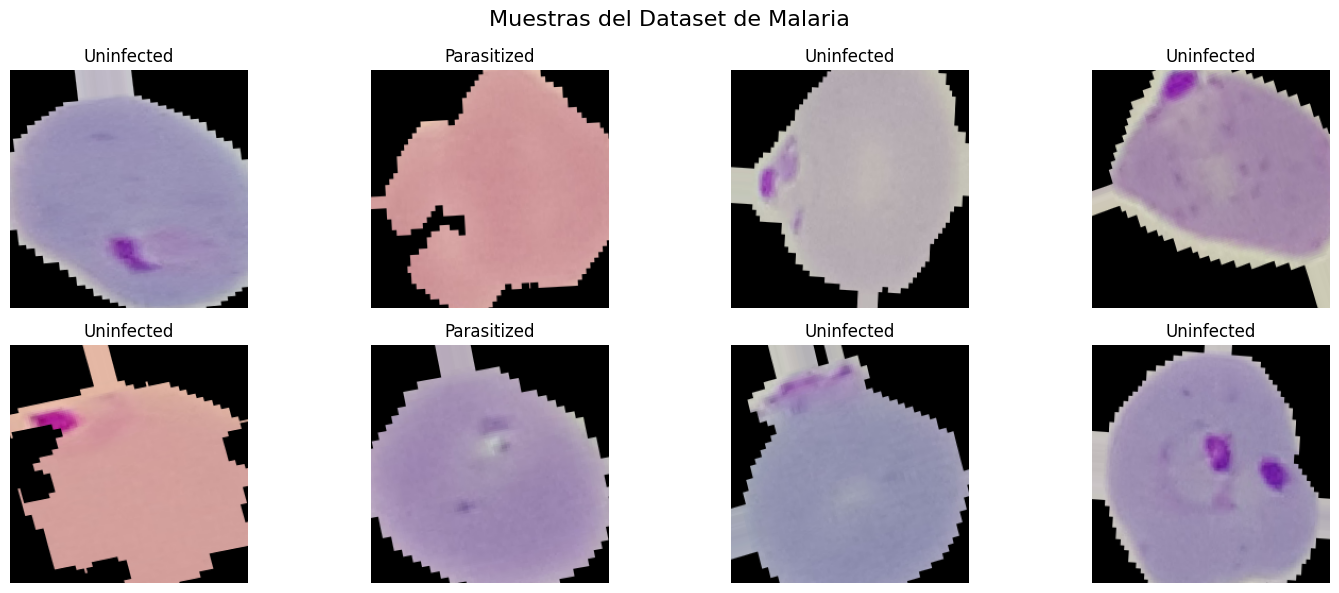

In [ ]:
def plot_sample_images():
    plt.figure(figsize=(15, 6))
    x_batch, y_batch = next(train_generator)

    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(x_batch[i])
        label = 'Parasitized' if y_batch[i] == 1 else 'Uninfected'
        plt.title(f'{label}')
        plt.axis('off')

    plt.suptitle('Muestras del Dataset de Malaria', fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'sample_images.png'), dpi=300, bbox_inches='tight')
    plt.show()

plot_sample_images()

#4. Entrenamiento

##MODELO A: VGG16

Definición del modelo

In [ ]:
def create_model_vgg16():
    """Crear modelo basado en VGG16"""
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMG_SIZE, 3)
    )

    # Congelar las capas base
    base_model.trainable = False

    # Agregar capas personalizadas
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    return model

print("=" * 50)
print("ENTRENANDO MODELO A: VGG16")
print("=" * 50)

model_vgg16 = create_model_vgg16()
model_vgg16.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model_vgg16.summary())

# Callbacks
callbacks_vgg16 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
]

ENTRENANDO MODELO A: VGG16
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


Proceso de entrenamiento

In [ ]:
# Entrenamiento
history_vgg16 = model_vgg16.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15,
    callbacks=callbacks_vgg16,
    verbose=1
)

Epoch 1/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 391s 544ms/step - accuracy: 0.6388 - loss: 0.6319 - val_accuracy: 0.7361 - val_loss: 0.4910 - learning_rate: 0.0010
Epoch 2/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 341s 495ms/step - accuracy: 0.7716 - loss: 0.4749 - val_accuracy: 0.7964 - val_loss: 0.4452 - learning_rate: 0.0010
Epoch 3/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 339s 492ms/step - accuracy: 0.7829 - loss: 0.4585 - val_accuracy: 0.8586 - val_loss: 0.3806 - learning_rate: 0.0010
Epoch 4/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 341s 494ms/step - accuracy: 0.8013 - loss: 0.4378 - val_accuracy: 0.8626 - val_loss: 0.3568 - learning_rate: 0.0010
Epoch 5/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 377s 487ms/step - accuracy: 0.7937 - loss: 0.4377 - val_accuracy: 0.8644 - val_loss: 0.3723 - learning_rate: 0.0010
Epoch 6/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 338s 490ms/step - accuracy: 0.8096 - loss: 0.4203 - val_accuracy: 0.8383 - val_loss: 0.3928 - learning_rate: 0.0010
Epoch 7/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 336s 488ms/step - accura

##MODELO B: ResNet50

Definición del modelo

In [ ]:
def create_model_resnet50():
    """Crear modelo basado en ResNet50"""
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMG_SIZE, 3)
    )

    # Congelar las capas base
    base_model.trainable = False

    # Agregar capas personalizadas
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    return model


Proceso de entrenamiento

In [ ]:
print("\n" + "=" * 50)
print("ENTRENANDO MODELO B: ResNet50")
print("=" * 50)

model_resnet50 = create_model_resnet50()
model_resnet50.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model_resnet50.summary())

# Callbacks
callbacks_resnet50 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
]

# Entrenamiento
history_resnet50 = model_resnet50.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15,
    callbacks=callbacks_resnet50,
    verbose=1
)


ENTRENANDO MODELO B: ResNet50
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

None
Epoch 1/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 334s 466ms/step - accuracy: 0.5171 - loss: 0.7370 - val_accuracy: 0.5367 - val_loss: 0.6869 - learning_rate: 0.0010
Epoch 2/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 317s 460ms/step - accuracy: 0.5407 - loss: 0.6889 - val_accuracy: 0.5087 - val_loss: 0.6877 - learning_rate: 0.0010
Epoch 3/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 321s 459ms/step - accuracy: 0.5504 - loss: 0.6864 - val_accuracy: 0.5497 - val_loss: 0.6811 - learning_rate: 0.0010
Epoch 4/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 321s 467ms/step - accuracy: 0.5724 - loss: 0.6804 - val_accuracy: 0.6230 - val_loss: 0.6762 - learning_rate: 0.0010
Epoch 5/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 307s 445ms/step - accuracy: 0.5647 - loss: 0.6785 - val_accuracy: 0.5163 - val_loss: 0.6868 - learning_rate: 0.0010
Epoch 6/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 308s 447ms/step - accuracy: 0.5740 - loss: 0.6776 - val_accuracy: 0.5608 - val_loss: 0.6733 - learning_rate: 0.0010
Epoch 7/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 307s 445ms/step - a

##MODELO C: EfficientNetB0

Definición del modelo

In [ ]:
def create_model_efficientnet():
    """Crear modelo basado en EfficientNetB0"""
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMG_SIZE, 3)
    )

    # Congelar las capas base
    base_model.trainable = False

    # Agregar capas personalizadas
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])

    return model

Proceso de entrenamiento

In [ ]:
print("ENTRENANDO MODELO C: EfficientNetB0")
print("=" * 50)

model_efficientnet = create_model_efficientnet()
model_efficientnet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model_efficientnet.summary())

# Callbacks
callbacks_efficientnet = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
]

# Entrenamiento
history_efficientnet = model_efficientnet.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15,
    callbacks=callbacks_efficientnet,
    verbose=1
)

ENTRENANDO MODELO C: EfficientNetB0
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,705,956 (17.95 MB)

 Trainable params: 656,385 (2.50 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

None
Epoch 1/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 341s 454ms/step - accuracy: 0.4949 - loss: 0.7077 - val_accuracy: 0.5000 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 2/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 291s 423ms/step - accuracy: 0.4973 - loss: 0.6938 - val_accuracy: 0.5000 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 3/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 293s 426ms/step - accuracy: 0.4912 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 4/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 294s 426ms/step - accuracy: 0.4960 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 5/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 292s 424ms/step - accuracy: 0.4993 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 2.0000e-04
Epoch 6/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 300s 435ms/step - accuracy: 0.4989 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932 - learning_rate: 2.0000e-04
Epoch 7/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 300s 436ms/

#5. Evaluación

Historial de entrenamiento

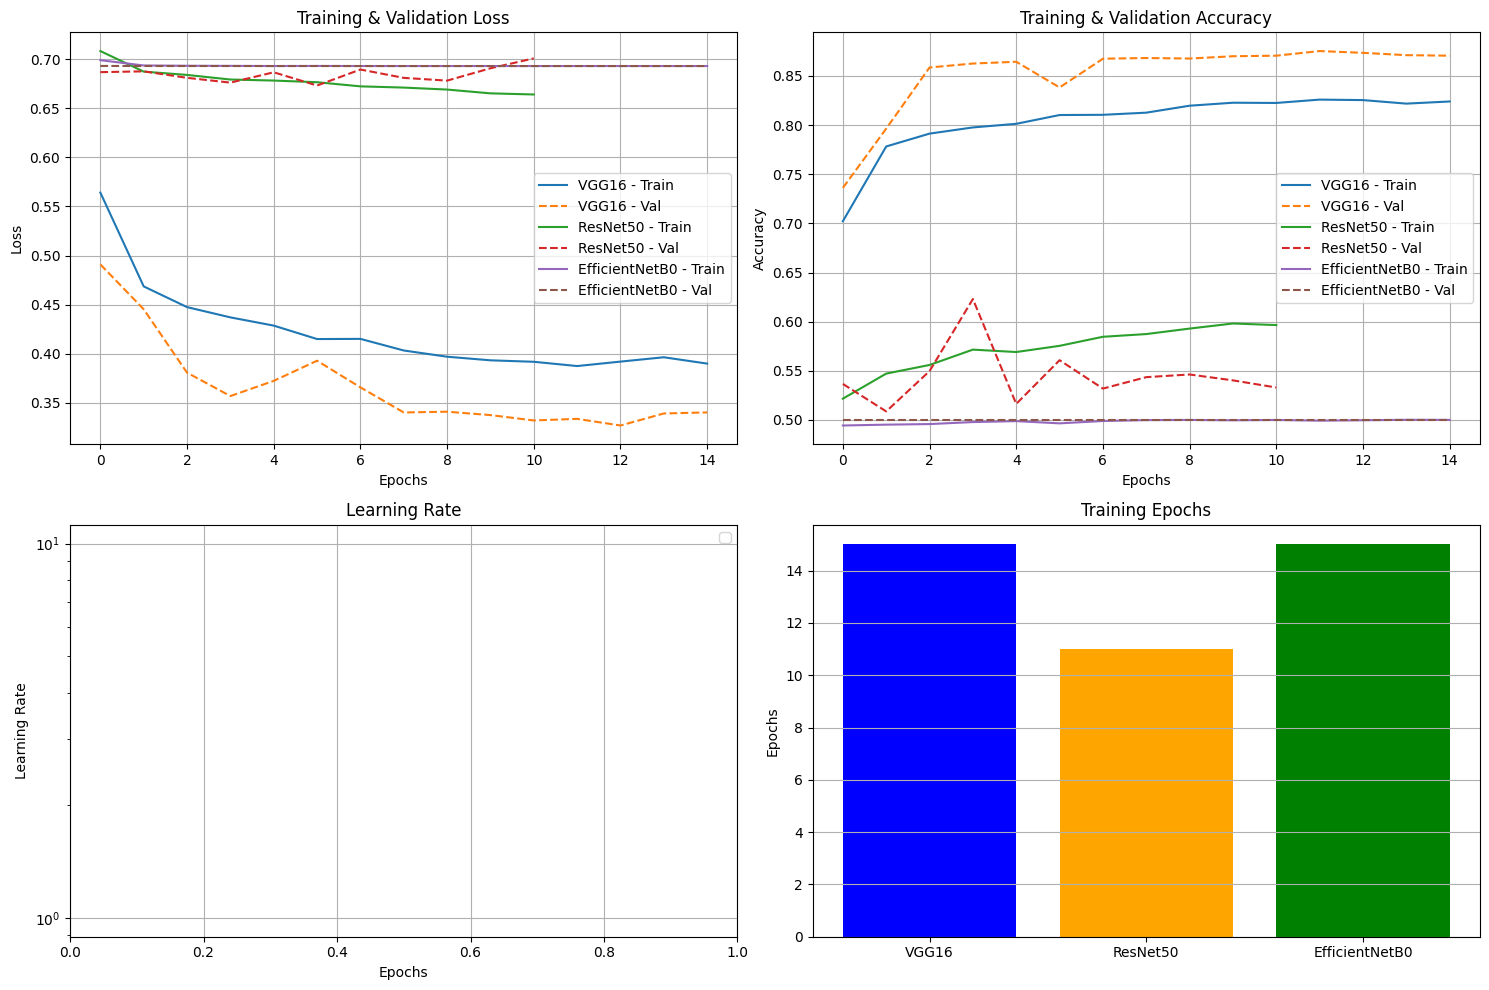

In [ ]:
def plot_training_history(histories, model_names):
    """Graficar historial de entrenamiento"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss
    axes[0, 0].set_title('Training & Validation Loss')
    for i, (history, name) in enumerate(zip(histories, model_names)):
        axes[0, 0].plot(history.history['loss'], label=f'{name} - Train')
        axes[0, 0].plot(history.history['val_loss'], label=f'{name} - Val', linestyle='--')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Accuracy
    axes[0, 1].set_title('Training & Validation Accuracy')
    for i, (history, name) in enumerate(zip(histories, model_names)):
        axes[0, 1].plot(history.history['accuracy'], label=f'{name} - Train')
        axes[0, 1].plot(history.history['val_accuracy'], label=f'{name} - Val', linestyle='--')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Learning Rate (si está disponible)
    axes[1, 0].set_title('Learning Rate')
    for i, (history, name) in enumerate(zip(histories, model_names)):
        if 'lr' in history.history:
            axes[1, 0].plot(history.history['lr'], label=f'{name}')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    axes[1, 0].set_yscale('log')

    # Epochs comparison
    axes[1, 1].set_title('Training Epochs')
    epochs = [len(h.history['loss']) for h in histories]
    axes[1, 1].bar(model_names, epochs, color=['blue', 'orange', 'green'])
    axes[1, 1].set_ylabel('Epochs')
    axes[1, 1].grid(True, axis='y')

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'training_history.png'), dpi=300, bbox_inches='tight')
    plt.show()

  # Graficar historial de entrenamiento
histories = [history_vgg16, history_resnet50, history_efficientnet]
model_names = ['VGG16', 'ResNet50', 'EfficientNetB0']
plot_training_history(histories, model_names)

Calculo de métricas

In [ ]:
def calculate_metrics(model, generator, model_name):
    """Calcular todas las métricas para un modelo"""
    print(f"\nCalculando métricas para {model_name}...")

    # Predicciones
    generator.reset()
    predictions = model.predict(generator, verbose=1)
    y_pred_binary = (predictions > 0.5).astype(int)
    y_true = generator.classes

    # Métricas
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_binary, average='macro')
    roc_auc = roc_auc_score(y_true, predictions)

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred_binary)

    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision_macro': precision,
        'recall_macro': recall,
        'f1_macro': f1,
        'roc_auc_macro': roc_auc,
        'confusion_matrix': cm,
        'predictions': predictions,
        'y_true': y_true,
        'y_pred': y_pred_binary
    }

# Calcular métricas para todos los modelos
models = [model_vgg16, model_resnet50, model_efficientnet]
results = []

for model, name in zip(models, model_names):
    result = calculate_metrics(model, validation_generator, name)
    results.append(result)

# Crear tabla comparativa
metrics_df = pd.DataFrame([
    {
        'Modelo': r['model'],
        'Accuracy': f"{r['accuracy']:.4f}",
        'Precision (Macro)': f"{r['precision_macro']:.4f}",
        'Recall (Macro)': f"{r['recall_macro']:.4f}",
        'F1 (Macro)': f"{r['f1_macro']:.4f}",
        'ROC-AUC (Macro)': f"{r['roc_auc_macro']:.4f}"
    } for r in results
])

print("\n" + "="*70)
print("TABLA COMPARATIVA DE MÉTRICAS")
print("="*70)
print(metrics_df.to_string(index=False))

# Guardar tabla
metrics_df.to_csv(os.path.join(RESULTS_DIR, 'metrics_comparison.csv'), index=False)


Calculando métricas para VGG16...
173/173 ━━━━━━━━━━━━━━━━━━━━ 29s 158ms/step

Calculando métricas para ResNet50...
173/173 ━━━━━━━━━━━━━━━━━━━━ 23s 111ms/step

Calculando métricas para EfficientNetB0...
173/173 ━━━━━━━━━━━━━━━━━━━━ 29s 121ms/step

TABLA COMPARATIVA DE MÉTRICAS
        Modelo Accuracy Precision (Macro) Recall (Macro) F1 (Macro) ROC-AUC (Macro)
         VGG16   0.8735            0.8758         0.8735     0.8733          0.9408
      ResNet50   0.5608            0.5849         0.5608     0.5272          0.6530
EfficientNetB0   0.5000            0.2500         0.5000     0.3333          0.5000


Gráfico de métricas

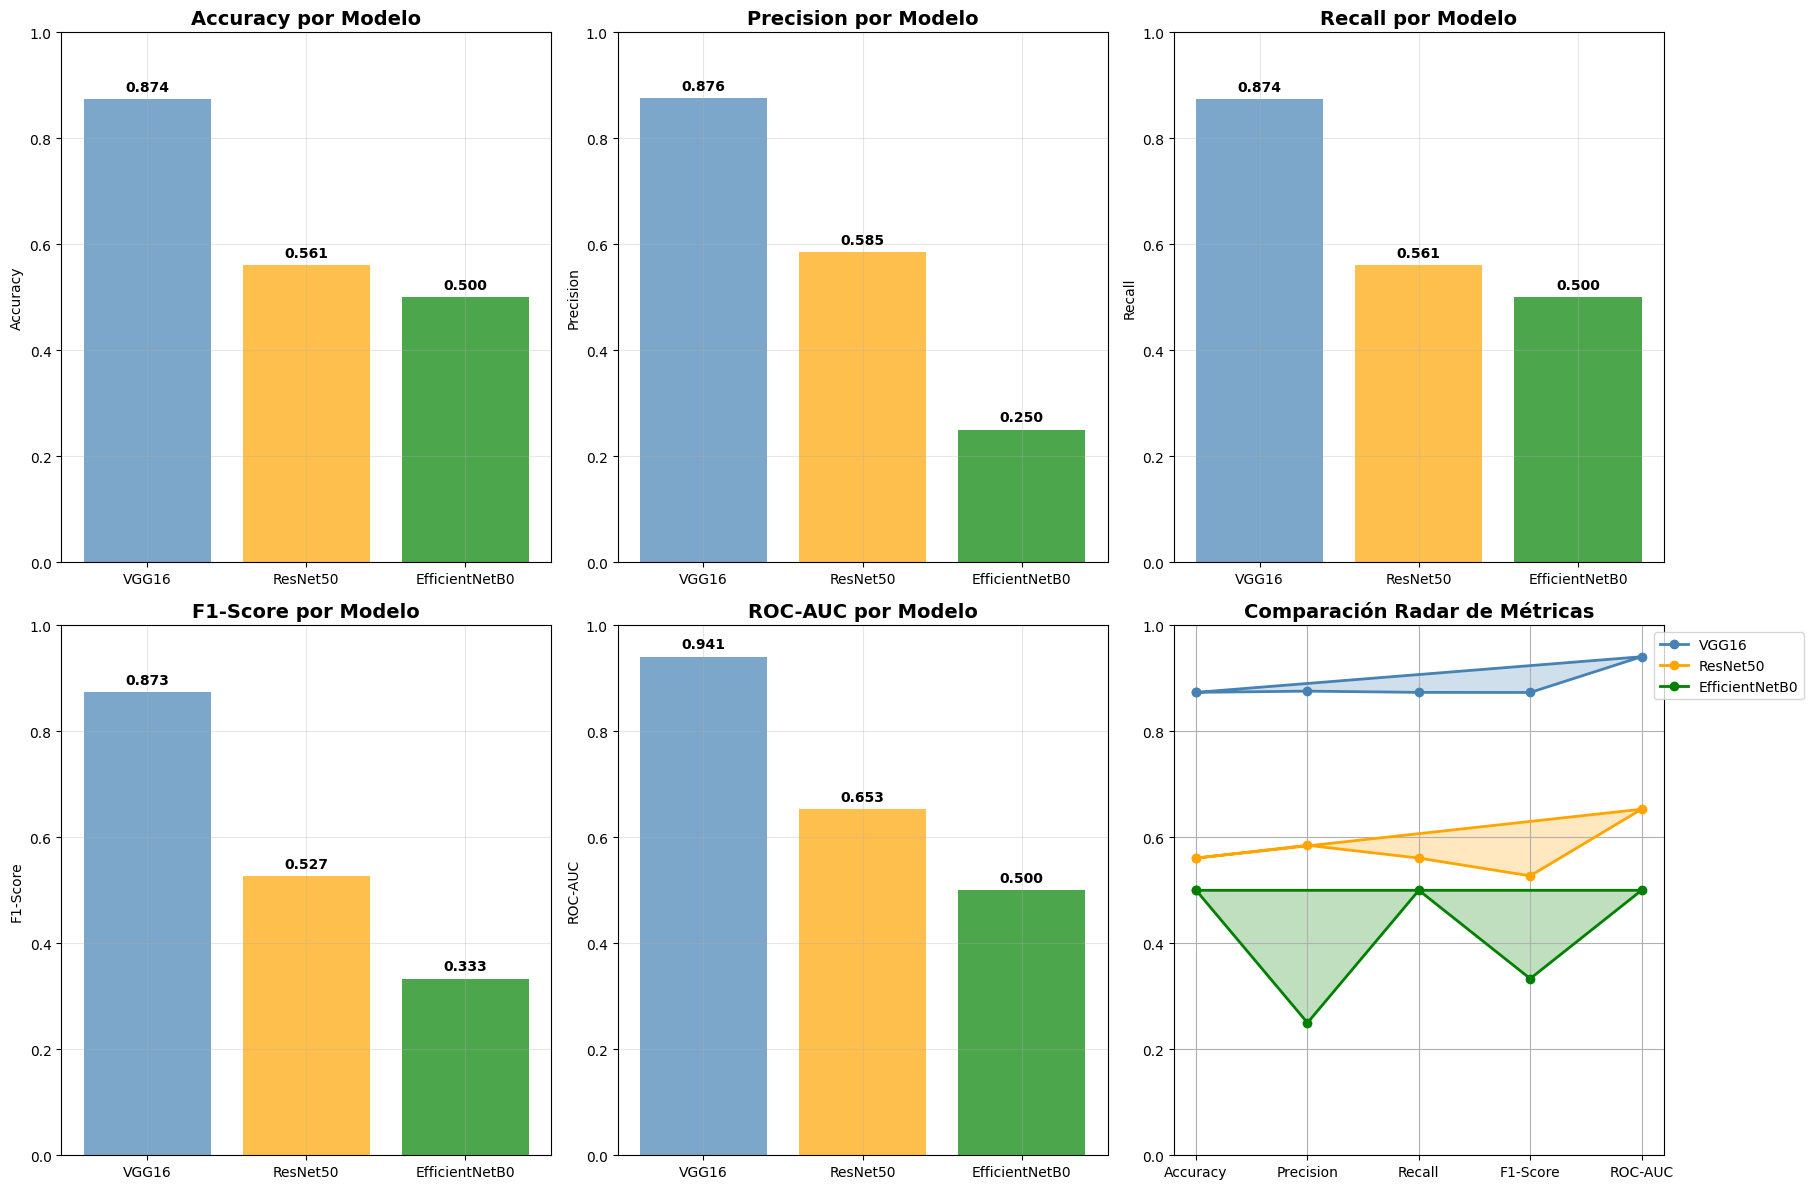

In [ ]:
# Gráfico de métricas
def plot_metrics_comparison():
    """Graficar comparación de métricas"""
    metrics_names = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc_macro']
    metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    # Gráfico de barras para cada métrica
    for i, (metric, label) in enumerate(zip(metrics_names, metric_labels)):
        values = [r[metric] for r in results]
        bars = axes[i].bar(model_names, values, color=['steelblue', 'orange', 'green'], alpha=0.7)
        axes[i].set_title(f'{label} por Modelo', fontsize=14, fontweight='bold')
        axes[i].set_ylabel(label)
        axes[i].set_ylim(0, 1)
        axes[i].grid(True, alpha=0.3)

        # Agregar valores en las barras
        for bar, value in zip(bars, values):
            axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    # Gráfico radar (comparación general)
    ax_radar = axes[5]
    angles = np.linspace(0, 2*np.pi, len(metric_labels), endpoint=False).tolist()
    angles += angles[:1]  # Cerrar el polígono

    colors = ['steelblue', 'orange', 'green']
    for i, (result, color, name) in enumerate(zip(results, colors, model_names)):
        values = [result[metric] for metric in metrics_names]
        values += values[:1]  # Cerrar el polígono

        ax_radar.plot(angles, values, 'o-', linewidth=2, label=name, color=color)
        ax_radar.fill(angles, values, alpha=0.25, color=color)

    ax_radar.set_xticks(angles[:-1])
    ax_radar.set_xticklabels(metric_labels)
    ax_radar.set_ylim(0, 1)
    ax_radar.set_title('Comparación Radar de Métricas', fontsize=14, fontweight='bold')
    ax_radar.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax_radar.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'metrics_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()

plot_metrics_comparison()

Matrices de Confusión

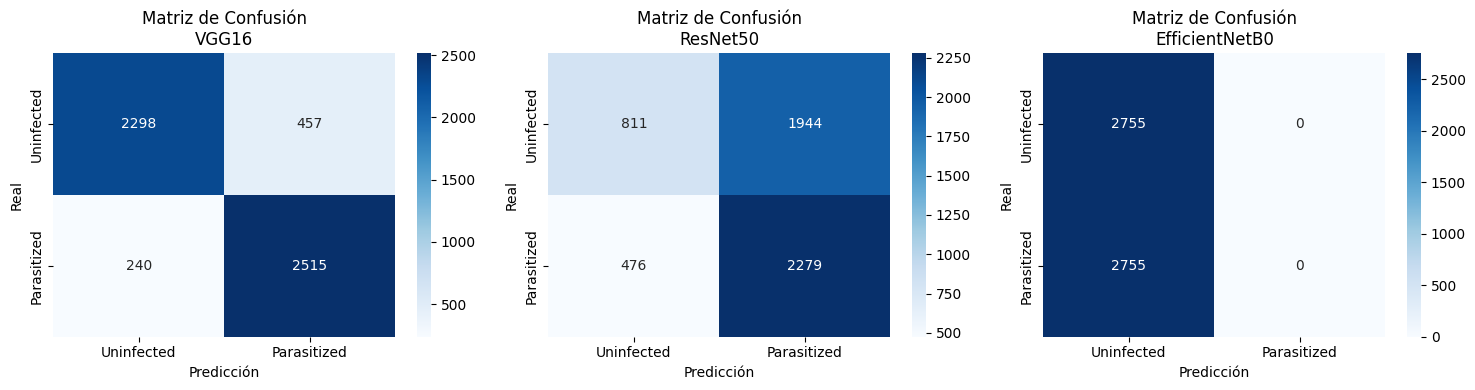

In [ ]:
# Matrices de confusión
def plot_confusion_matrices():
    """Graficar matrices de confusión"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    class_names = ['Uninfected', 'Parasitized']

    for i, (result, ax) in enumerate(zip(results, axes)):
        cm = result['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=class_names, yticklabels=class_names)
        ax.set_title(f'Matriz de Confusión\n{result["model"]}')
        ax.set_xlabel('Predicción')
        ax.set_ylabel('Real')

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'confusion_matrices.png'), dpi=300, bbox_inches='tight')
    plt.show()

plot_confusion_matrices()

Inferencias de Ejemplo


INFERENCIA EN MUESTRAS DE EJEMPLO


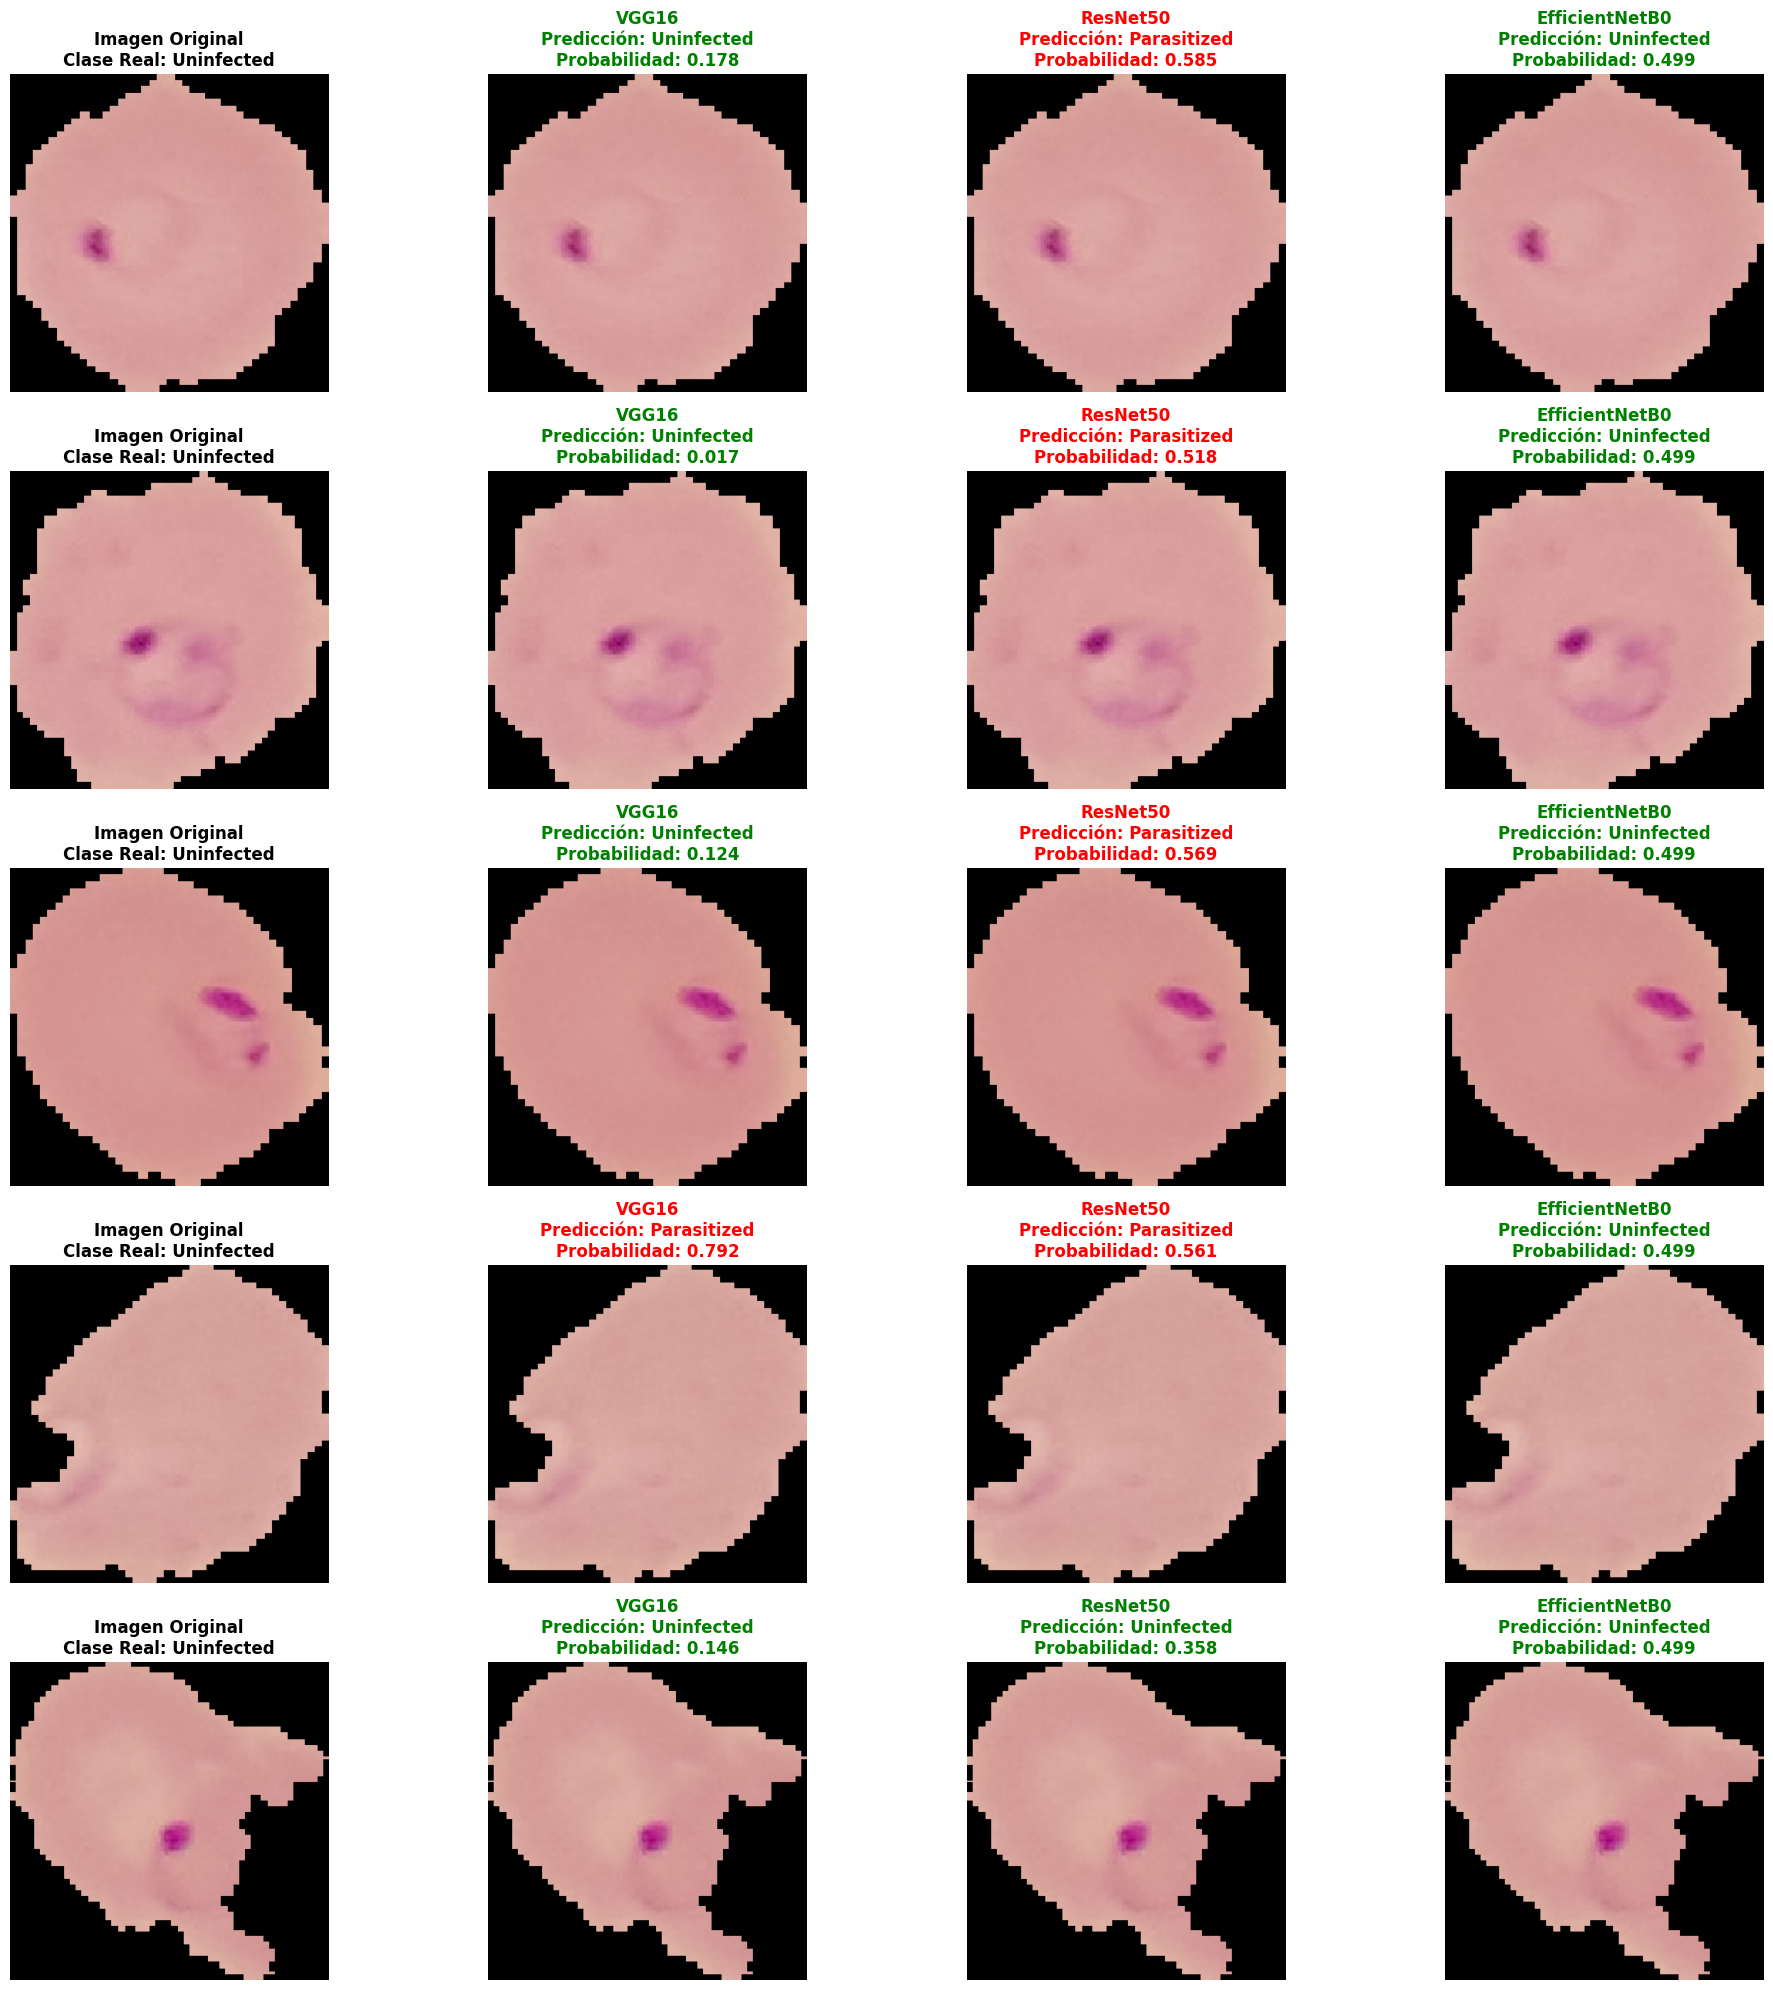

In [ ]:
def predict_sample_images(models, model_names, num_samples=5):
    """Realizar inferencia en imágenes de ejemplo"""
    # Obtener muestras de validación
    validation_generator.reset()
    x_batch, y_batch = next(validation_generator)

    # Seleccionar algunas imágenes
    indices = np.random.choice(len(x_batch), num_samples, replace=False)

    fig, axes = plt.subplots(num_samples, len(models) + 1, figsize=(20, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    class_names = ['Uninfected', 'Parasitized']

    for i, idx in enumerate(indices):
        image = x_batch[idx]
        true_label = int(y_batch[idx])
        true_class = class_names[true_label]

        # Mostrar imagen original
        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f'Imagen Original\nClase Real: {true_class}', fontweight='bold')
        axes[i, 0].axis('off')

        # Predicciones de cada modelo
        for j, (model, name) in enumerate(zip(models, model_names)):
            # Predicción
            pred_prob = model.predict(np.expand_dims(image, 0), verbose=0)[0][0]
            pred_class = class_names[int(pred_prob > 0.5)]

            # Color según si es correcto o no
            color = 'green' if pred_class == true_class else 'red'

            axes[i, j+1].imshow(image)
            axes[i, j+1].set_title(f'{name}\nPredicción: {pred_class}\nProbabilidad: {pred_prob:.3f}',
                                  color=color, fontweight='bold')
            axes[i, j+1].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'sample_predictions.png'), dpi=300, bbox_inches='tight')
    plt.show()

    return indices, x_batch, y_batch

print("\n" + "="*50)
print("INFERENCIA EN MUESTRAS DE EJEMPLO")
print("="*50)

# Realizar predicciones de ejemplo
sample_indices, sample_images, sample_labels = predict_sample_images(models, model_names)

Resultados Detallados de Inferencia

In [ ]:
print("\nRESULTADOS DETALLADOS DE INFERENCIA:")
print("-" * 80)

class_names = ['Uninfected', 'Parasitized']
inference_results = []

for i, idx in enumerate(sample_indices):
    true_label = int(sample_labels[idx])
    true_class = class_names[true_label]

    print(f"\nImagen {i+1} - Clase Real: {true_class}")
    print("-" * 40)

    row = {'Imagen': f'Muestra {i+1}', 'Clase_Real': true_class}

    for model, name in zip(models, model_names):
        pred_prob = model.predict(np.expand_dims(sample_images[idx], 0), verbose=0)[0][0]
        pred_class = class_names[int(pred_prob > 0.5)]
        correct = "✓" if pred_class == true_class else "✗"

        print(f"{name:15} | {pred_class:12} | {pred_prob:.3f} | {correct}")

        row[f'{name}_Pred'] = pred_class
        row[f'{name}_Prob'] = f"{pred_prob:.3f}"
        row[f'{name}_Correct'] = correct

    inference_results.append(row)

# Guardar resultados de inferencia
inference_df = pd.DataFrame(inference_results)
inference_df.to_csv(os.path.join(RESULTS_DIR, 'inference_results.csv'), index=False)


RESULTADOS DETALLADOS DE INFERENCIA:
--------------------------------------------------------------------------------

Imagen 1 - Clase Real: Uninfected
----------------------------------------
VGG16           | Uninfected   | 0.178 | ✓
ResNet50        | Parasitized  | 0.585 | ✗
EfficientNetB0  | Uninfected   | 0.499 | ✓

Imagen 2 - Clase Real: Uninfected
----------------------------------------
VGG16           | Uninfected   | 0.017 | ✓
ResNet50        | Parasitized  | 0.518 | ✗
EfficientNetB0  | Uninfected   | 0.499 | ✓

Imagen 3 - Clase Real: Uninfected
----------------------------------------
VGG16           | Uninfected   | 0.124 | ✓
ResNet50        | Parasitized  | 0.569 | ✗
EfficientNetB0  | Uninfected   | 0.499 | ✓

Imagen 4 - Clase Real: Uninfected
----------------------------------------
VGG16           | Parasitized  | 0.792 | ✗
ResNet50        | Parasitized  | 0.561 | ✗
EfficientNetB0  | Uninfected   | 0.499 | ✓

Imagen 5 - Clase Real: Uninfected
--------------------------

Guardar modelos

In [ ]:
print("\n" + "="*50)
print("GUARDANDO RESULTADOS Y MODELOS")
print("="*50)

# Guardar modelos
model_vgg16.save(os.path.join(RESULTS_DIR, 'model_vgg16.h5'))
model_resnet50.save(os.path.join(RESULTS_DIR, 'model_resnet50.h5'))
model_efficientnet.save(os.path.join(RESULTS_DIR, 'model_efficientnet.h5'))

print("✓ Modelos guardados")

# Guardar historiales de entrenamiento
import pickle

with open(os.path.join(RESULTS_DIR, 'training_histories.pkl'), 'wb') as f:
    pickle.dump({
        'vgg16': history_vgg16.history,
        'resnet50': history_resnet50.history,
        'efficientnet': history_efficientnet.history
    }, f)

print("✓ Historiales de entrenamiento guardados")


GUARDANDO RESULTADOS Y MODELOS


✓ Modelos guardados
✓ Historiales de entrenamiento guardados


Resumen Ejecutivo

In [ ]:
# Crear resumen ejecutivo
summary_report = f"""
RESUMEN EJECUTIVO - CLASIFICACIÓN DE MALARIA
=============================================

Dataset: Cell Images for Detecting Malaria
Clases: Uninfected, Parasitized
Total de imágenes: {sum(class_counts.values())}
Imágenes de entrenamiento: {train_generator.samples}
Imágenes de validación: {validation_generator.samples}

MODELOS EVALUADOS:
------------------
1. VGG16 + Transfer Learning
2. ResNet50 + Transfer Learning
3. EfficientNetB0 + Transfer Learning

MÉTRICAS PRINCIPALES:
--------------------
"""

# Agregar métricas de cada modelo
for result in results:
    summary_report += f"""
{result['model']}:
  - Accuracy: {result['accuracy']:.4f}
  - Precision (Macro): {result['precision_macro']:.4f}
  - Recall (Macro): {result['recall_macro']:.4f}
  - F1-Score (Macro): {result['f1_macro']:.4f}
  - ROC-AUC (Macro): {result['roc_auc_macro']:.4f}
"""

# Encontrar el mejor modelo
best_model_idx = np.argmax([r['f1_macro'] for r in results])
best_model_name = results[best_model_idx]['model']
best_f1 = results[best_model_idx]['f1_macro']

summary_report += f"""
MODELO RECOMENDADO:
------------------
{best_model_name} con F1-Score de {best_f1:.4f}

ARCHIVOS GENERADOS:
------------------
- training_history.png: Gráficos de entrenamiento
- metrics_comparison.png: Comparación de métricas
- confusion_matrices.png: Matrices de confusión
- sample_predictions.png: Predicciones de ejemplo
- metrics_comparison.csv: Tabla de métricas
- inference_results.csv: Resultados de inferencia
- model_*.h5: Modelos entrenados
- training_histories.pkl: Historiales de entrenamiento
"""

# Guardar resumen
with open(os.path.join(RESULTS_DIR, 'summary_report.txt'), 'w', encoding='utf-8') as f:
    f.write(summary_report)

print("✓ Resumen ejecutivo guardado")

✓ Resumen ejecutivo guardado


Evaluación de modelos Guardados. Esta celda es para cargar los modelos ya entrenados guardados en Drive para visualizar rápidamente sus métricas.

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mounted at /content/drive
Dataset path inicial: /kaggle/input/cell-images-for-detecting-malaria
Parasitized: 13779 imágenes
Uninfected: 13779 imágenes
Total de imágenes: 27558
Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.
✓ VGG16 cargado y compilado
✓ ResNet50 cargado y compilado
✓ EfficientNetB0 cargado y compilado

✓ 3 modelos cargados exitosamente

--- Evaluando VGG16 ---
Calculando métricas para VGG16 en Train...
  Procesado 10/50 batches...
  Procesado 20/50 batches...
  Procesado 30/50 batches...
  Procesado 40/50 batches...
✓ VGG16 Train: Accuracy=0.8819, F1=0.8819
Calculando métricas para VGG16 en Test...
  Procesado 10/173 batches...
  Procesado 20/173 batches...
  Procesado 30/173 batches...
  Procesado 40/173 batches...
  Procesado 50/173 batches...
  Procesado 60/173 batches...
  Procesado 70/173 batches...
  Procesado 80/173 batches...
  Procesado 90/17

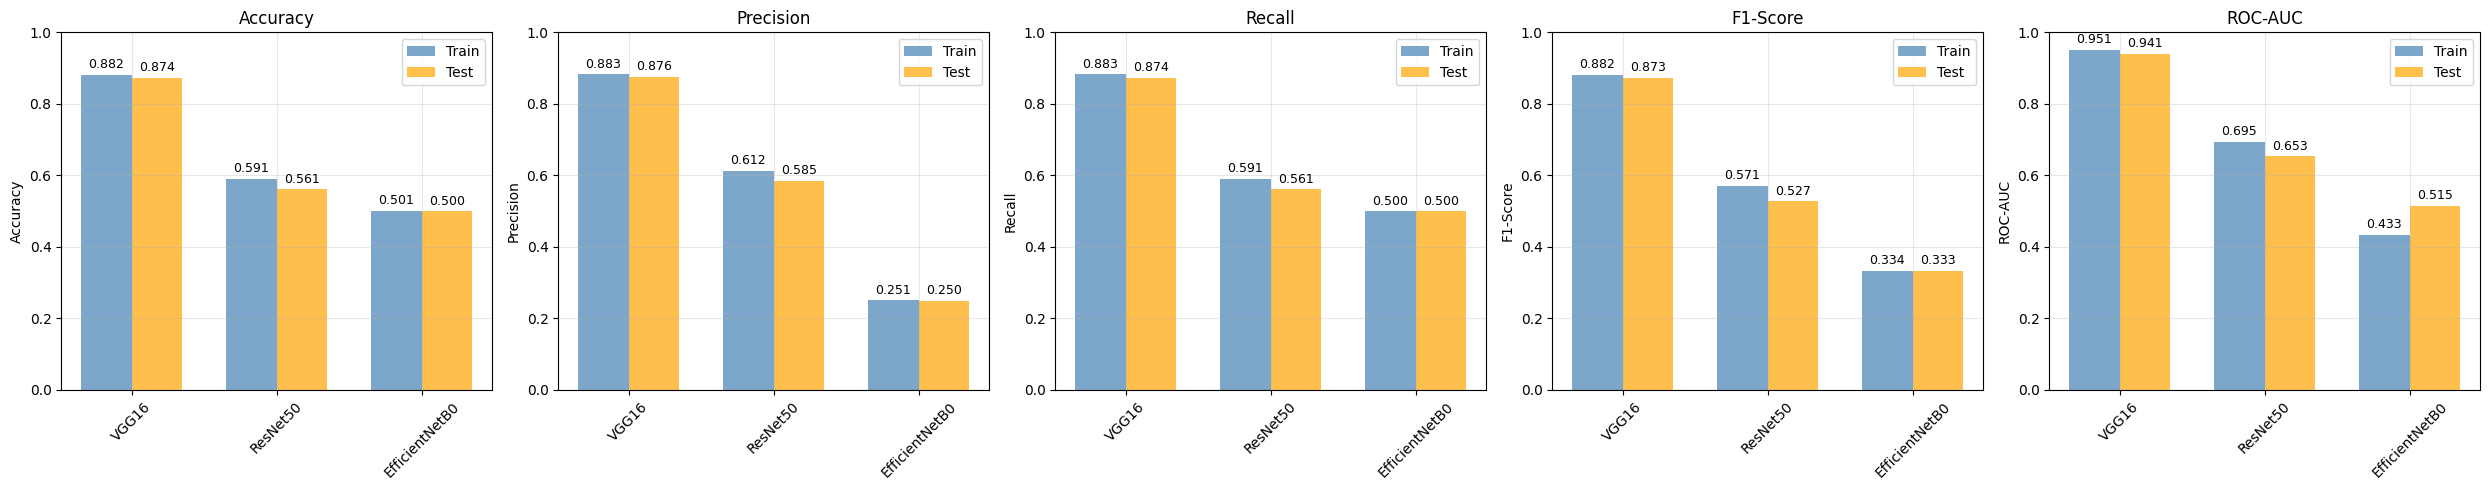


EVALUACIÓN COMPLETADA EXITOSAMENTE ✓
Modelos evaluados: 3
Mejor modelo: VGG16
F1-Score (Test): 0.8733

Archivos generados:
✓ metrics_comparison(train vs test).csv
✓ metrics_comparison(train vs test).png

📁 Resultados guardados en: /content/drive/MyDrive/DL_Proyecto_MorenoBryan_Clasificacion/results


In [1]:
#-----------------------------------Importaciones--------------------------------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# TensorFlow y Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Sklearn para métricas
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

#---------------------------------------------Configuración de directorios-------------------------------
PROJECT_ROOT = '/content/drive/MyDrive/DL_Proyecto_MorenoBryan_Clasificacion'
RESULTS_DIR = os.path.join(PROJECT_ROOT, 'results')

#---------------------------------------------------Montar Google Drive------------------------------------
from google.colab import drive
drive.mount('/content/drive')

#----------------------------------------------Carga del Dataset---------------------------
import kagglehub
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")
print(f"Dataset path inicial: {path}")
data_path = path + "/cell_images/cell_images"
train_dir = os.path.join(data_path, 'train') if os.path.exists(os.path.join(data_path, 'train')) else data_path
# Verificar las clases y contar imágenes
classes = ['Parasitized', 'Uninfected']
class_counts = {}
for class_name in classes:
    class_path = os.path.join(data_path, class_name)
    if os.path.exists(class_path):
        count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        class_counts[class_name] = count
        print(f"{class_name}: {count} imágenes")
print(f"Total de imágenes: {sum(class_counts.values())}")

#-----------------------------------Configuración de parámetros del entrenamiento--------------------------------
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT
)


train_generator = datagen.flow_from_directory(
    data_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)


validation_generator = datagen.flow_from_directory(
    data_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=42
)

#--------------------------------------Carga de Modelos------------------------------------
model_files = [
    'model_vgg16.h5',
    'model_resnet50.h5',
    'model_efficientnet.h5'
]

model_names = ['VGG16', 'ResNet50', 'EfficientNetB0']


loaded_models = []
for model_file, name in zip(model_files, model_names):
    model_path = os.path.join(RESULTS_DIR, model_file)

    try:
        model = keras.models.load_model(model_path, compile=False)

        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        loaded_models.append(model)
        print(f"✓ {name} cargado y compilado")
    except Exception as e:
        print(f"✗ Error cargando {name}: {str(e)}")

print(f"\n✓ {len(loaded_models)} modelos cargados exitosamente")

#--------------------------------------Cálculo de Métricas----------------------------------------
def calculate_metrics_fast(model, generator, model_name, dataset_type, max_batches=None):
    """Calcular métricas de forma optimizada"""
    print(f"Calculando métricas para {model_name} en {dataset_type}...")

    generator.reset()

    predictions_list = []
    y_true_list = []
    batch_count = 0

    total_batches = len(generator) if max_batches is None else min(max_batches, len(generator))

    for batch_x, batch_y in generator:
        batch_pred = model.predict(batch_x, verbose=0)
        predictions_list.extend(batch_pred.flatten())
        y_true_list.extend(batch_y)

        batch_count += 1
        if batch_count >= total_batches:
            break

        if batch_count % 10 == 0:
            print(f"  Procesado {batch_count}/{total_batches} batches...")

    # Convertir a arrays
    predictions = np.array(predictions_list)
    y_true = np.array(y_true_list)
    y_pred_binary = (predictions > 0.5).astype(int)

    # Calcular métricas
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_binary, average='macro')
    # Manejar el caso de una sola clase
    if len(np.unique(y_true)) > 1:
        roc_auc = roc_auc_score(y_true, predictions)
    else:
        roc_auc = np.nan

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred_binary)

    print(f"✓ {model_name} {dataset_type}: Accuracy={accuracy:.4f}, F1={f1:.4f}")

    return {
        'model': model_name,
        'dataset': dataset_type,
        'accuracy': accuracy,
        'precision_macro': precision,
        'recall_macro': recall,
        'f1_macro': f1,
        'roc_auc_macro': roc_auc,
        'confusion_matrix': cm,
        'samples_evaluated': len(y_true)
    }

#-------------------------------Cálculo de métricas para todos los modelos----------------------------

all_results = []

TRAIN_MAX_BATCHES = 50
TEST_MAX_BATCHES = None

for i, (model, name) in enumerate(zip(loaded_models, model_names[:len(loaded_models)])):
    print(f"\n--- Evaluando {name} ---")

    train_result = calculate_metrics_fast(
        model, train_generator, name, 'Train', max_batches=TRAIN_MAX_BATCHES
    )
    all_results.append(train_result)

    test_result = calculate_metrics_fast(
        model, validation_generator, name, 'Test', max_batches=TEST_MAX_BATCHES
    )
    all_results.append(test_result)

#-------------------------------------------------Tabla Comparativa--------------------------------
# Organizar datos para tabla comparativa
comparative_data = []
successful_models = len(loaded_models)

for i in range(successful_models):
    if i*2 + 1 < len(all_results):
        train_metrics = all_results[i*2]
        test_metrics = all_results[i*2 + 1]
        model_name = train_metrics['model']

        changes_dict = {
            'VGG16': "VGG16 base + GAP + Dense(128) + Dropout",
            'ResNet50': "ResNet50 base + GAP + Dense(256) + Dropout",
            'EfficientNetB0': "EfficientNetB0 base + GAP + Dense(512) + Dropout"
        }

        comparative_data.append({
            'Variante/Modelo': model_name,
            'Resumen de cambios': changes_dict.get(model_name, "Transfer Learning"),
            'Accuracy Train': f"{train_metrics['accuracy']:.4f}",
            'Accuracy Test': f"{test_metrics['accuracy']:.4f}",
            'Precision Train': f"{train_metrics['precision_macro']:.4f}",
            'Precision Test': f"{test_metrics['precision_macro']:.4f}",
            'Recall Train': f"{train_metrics['recall_macro']:.4f}",
            'Recall Test': f"{test_metrics['recall_macro']:.4f}",
            'F1-Score Train': f"{train_metrics['f1_macro']:.4f}",
            'F1-Score Test': f"{test_metrics['f1_macro']:.4f}",
            'ROC-AUC Train': f"{train_metrics['roc_auc_macro']:.4f}",
            'ROC-AUC Test': f"{test_metrics['roc_auc_macro']:.4f}",
            'Observaciones': f"Transfer Learning (Train: {train_metrics['samples_evaluated']} muestras)"
        })

# Crear y mostrar tabla
if comparative_data:
    comparative_df = pd.DataFrame(comparative_data)
    print(comparative_df.to_string(index=False))

    # Guardar tabla
    comparative_df.to_csv(os.path.join(RESULTS_DIR, 'metrics_comparison(train vs test).csv'), index=False)

#------------------------------------------------Gráfico Comparativo de métricas----------------------------------

def plot_quick_comparison():
    if len(all_results) < 2:
        return

    # Separar train y test
    train_results = [all_results[i*2] for i in range(successful_models)]
    test_results = [all_results[i*2 + 1] for i in range(successful_models)]

    # Métricas principales
    metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc_macro']
    labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

    fig, axes = plt.subplots(1, 5, figsize=(25, 5))

    for i, (metric, label) in enumerate(zip(metrics, labels)):
        train_vals = [r[metric] for r in train_results]
        test_vals = [r[metric] for r in test_results]

        x = np.arange(len(train_vals))
        width = 0.35

        axes[i].bar(x - width/2, train_vals, width, label='Train', alpha=0.7, color='steelblue')
        axes[i].bar(x + width/2, test_vals, width, label='Test', alpha=0.7, color='orange')

        axes[i].set_title(f'{label}')
        axes[i].set_ylabel(label)
        axes[i].set_xticks(x)
        axes[i].set_xticklabels([r['model'] for r in train_results], rotation=45)
        axes[i].legend()
        axes[i].set_ylim(0, 1)
        axes[i].grid(True, alpha=0.3)

        # Valores en barras
        for j, (train_val, test_val) in enumerate(zip(train_vals, test_vals)):
            axes[i].text(j - width/2, train_val + 0.01, f'{train_val:.3f}',
                         ha='center', va='bottom', fontsize=9)
            axes[i].text(j + width/2, test_val + 0.01, f'{test_val:.3f}',
                         ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'metrics_comparison(train vs test).png'), dpi=300, bbox_inches='tight')
    plt.show()

plot_quick_comparison()

#----------------------------------------------------------Resumen de Ejecución----------------------------------------------

if all_results and comparative_data:
    # Mejor modelo
    test_results = [all_results[i*2 + 1] for i in range(successful_models)]
    best_idx = np.argmax([r['f1_macro'] for r in test_results])
    best_model = test_results[best_idx]['model']
    best_f1 = test_results[best_idx]['f1_macro']

    print("\n" + "="*80)
    print("EVALUACIÓN COMPLETADA EXITOSAMENTE ✓")
    print("="*80)
    print(f"Modelos evaluados: {successful_models}")
    print(f"Mejor modelo: {best_model}")
    print(f"F1-Score (Test): {best_f1:.4f}")
    print(f"\nArchivos generados:")
    print(f"✓ metrics_comparison(train vs test).csv")
    print(f"✓ metrics_comparison(train vs test).png")
else:
    print("No se pudieron generar los resultados completos")
    print("Verifica que los modelos se cargaron correctamente")

print(f"\n📁 Resultados guardados en: {RESULTS_DIR}")